In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

In [2]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding=3), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [3]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=360, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

def preprocess_putty_log(file_path):
    raw_data = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line or '=' in line or 'PuTTY' in line: continue
            clean_val = "".join(filter(str.isdigit, line))
            if clean_val: raw_data.append(float(clean_val))
    return np.array(raw_data)

def create_dashboard(raw_sig, proc_sig, probs, classes, pred_idx):
    plt.rcParams['font.family'] = 'sans-serif'
    fig = plt.figure(figsize=(18, 12), facecolor='#0b0d10')
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])
    
    accent_color = '#00f2ff'
    anomaly_color = '#ff3366'
    text_color = '#e0e0e0'

    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_facecolor('#0b0d10')
    
    ax1.plot(raw_sig, color='#444444', alpha=0.4, label='Raw Sensor Input')
    ax1.plot(proc_sig * (np.max(raw_sig)/np.max(proc_sig)), color=accent_color, linewidth=2, label='AI Filtered Signal')
    
    if classes[pred_idx] != 'N':
        ax1.axvspan(140, 220, color=anomaly_color, alpha=0.15, label='Anomaly Detection Zone')
        ax1.annotate('ANOMALY PATTERN DETECTED', xy=(180, np.max(raw_sig)), xytext=(180, np.max(raw_sig)*1.15),
                     color=anomaly_color, weight='bold', fontsize=12, ha='center',
                     arrowprops=dict(arrowstyle='->', color=anomaly_color))

    ax1.set_title("SIGNAL ANALYSIS & ANOMALY LOCALIZATION", color=text_color, fontsize=16, loc='left', pad=20)
    ax1.legend(facecolor='#1a1c23', edgecolor='none', labelcolor=text_color, loc='upper right')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_facecolor('#1a1c23')
    class_info = [
        ("N", "Normal Sinus Rhythm", "0.94"),
        ("L", "Left Bundle Block", "0.98"),
        ("R", "Right Bundle Block", "0.98"),
        ("V", "Ventricular Contrac.", "0.81"),
        ("A", "Atrial Premature", "0.55"),
        ("F", "Fusion Beat", "0.37")
    ]
    ax2.text(0.1, 0.9, "DIAGNOSTIC KEY", color=accent_color, fontsize=16, weight='bold')
    for i, (code, desc, f1) in enumerate(class_info):
        y_pos = 0.75 - (i * 0.12)
        is_pred = classes[pred_idx] == code
        color = anomaly_color if (is_pred and code != 'N') else (accent_color if is_pred else text_color)
        weight = 'bold' if is_pred else 'normal'
        ax2.text(0.1, y_pos, f"{code}: {desc}", color=color, fontsize=12, weight=weight)
        ax2.text(0.8, y_pos, f"F1: {f1}", color=color, fontsize=10, alpha=0.7)
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[1, 1], polar=True)
    ax3.set_facecolor('#1a1c23')
    angles = np.linspace(0, 2 * np.pi, len(classes), endpoint=False).tolist()
    r_probs = probs.tolist() + [probs[0]]
    r_angles = angles + [angles[0]]
    chart_color = anomaly_color if classes[pred_idx] != 'N' else accent_color
    ax3.fill(r_angles, r_probs, color=chart_color, alpha=0.3)
    ax3.plot(r_angles, r_probs, color=chart_color, linewidth=3, marker='o', markersize=8)
    ax3.set_xticks(angles)
    ax3.set_xticklabels(classes, color=text_color, fontsize=14, weight='bold')
    ax3.grid(color='#333333')
    ax3.set_yticklabels([])
    ax3.set_title("MODEL CONFIDENCE MAP", color=text_color, pad=30)

    ax4 = fig.add_subplot(gs[1, 2])
    ax4.set_facecolor('#1a1c23')
    res_color = anomaly_color if classes[pred_idx] != 'N' else accent_color
    ax4.text(0.5, 0.65, f"{classes[pred_idx]}", color=res_color, fontsize=90, weight='bold', ha='center')
    ax4.text(0.5, 0.4, "CLASSIFICATION", color=text_color, fontsize=18, ha='center')
    ax4.text(0.5, 0.25, f"Probability: {probs[pred_idx]*100:.2f}%", color=res_color, fontsize=14, ha='center')
    if classes[pred_idx] != 'N':
        ax4.text(0.5, 0.1, "🚨 ANOMALY ALERT", color=anomaly_color, fontsize=16, weight='bold', ha='center')
    ax4.axis('off')

    plt.suptitle(f"ECG INTELLIGENCE DASHBOARD | 1D-CNN ARCHITECTURE", color=text_color, fontsize=24, y=0.96, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("ecg_anomaly_highlight.png", dpi=300, facecolor='#0b0d10')
    plt.show()

def run_dashboard(log_path, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classes = ['A', 'F', 'L', 'N', 'R', 'V']
    model = CNN1D(num_classes=6).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    raw_signal = preprocess_putty_log(log_path)
    if len(raw_signal) < 360: return
    
    raw_window = raw_signal[:360]
    proc_window = bandpass_filter(raw_window)
    norm_window = (proc_window - np.mean(proc_window)) / (np.std(proc_window) + 1e-8)
    input_tensor = torch.tensor(norm_window, dtype=torch.float32).view(1, 1, -1).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)

    create_dashboard(raw_window, norm_window, probs, classes, pred_idx)

C:\Users\Informatics\AppData\Local\Temp\ipykernel_4468\1170141610.py:86: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\Informatics\AppData\Local\Temp\ipykernel_4468\1170141610.py:87: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig("ecg_anomaly_highlight.png", dpi=300, facecolor='#0b0d10')
c:\Users\Informatics\Desktop\RhythmIQ\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


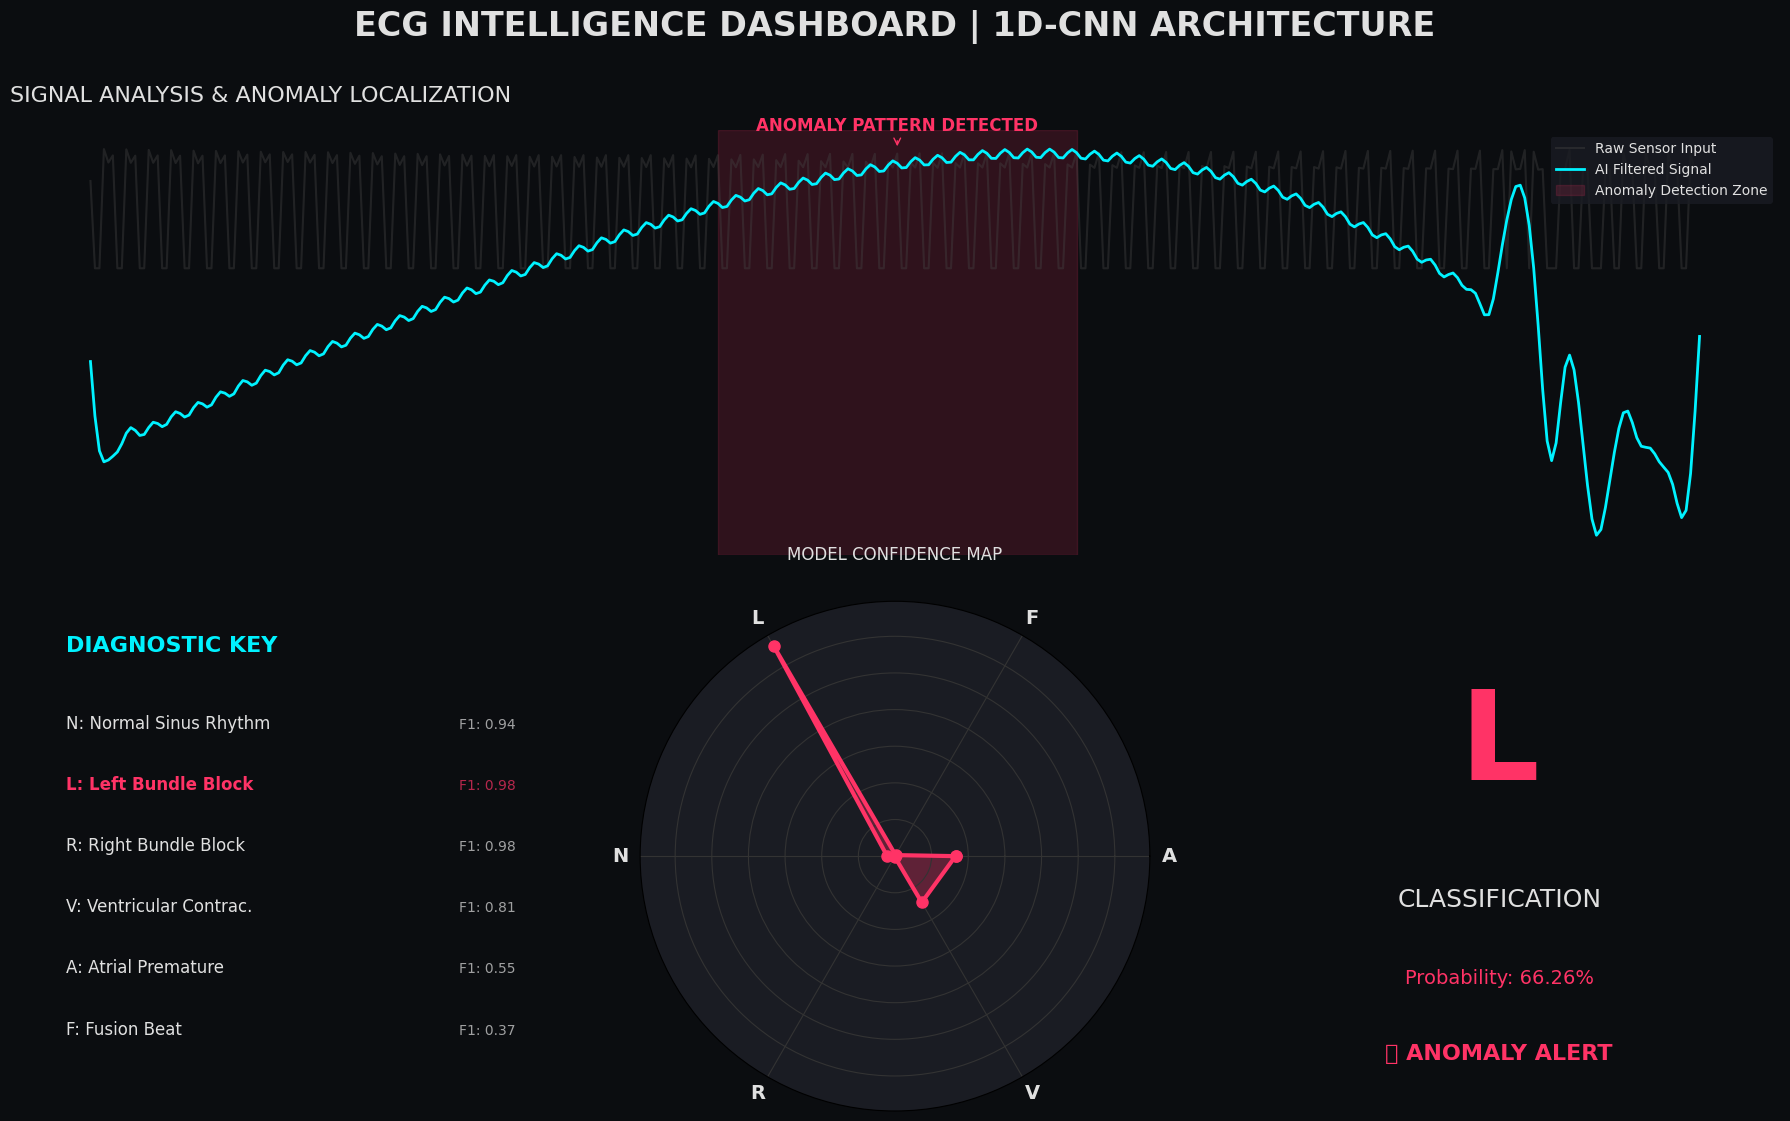

In [4]:
run_dashboard("ecg_sample.txt", "cnn1d_mitbih_augmented.pth")